In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [3]:
import sys
sys.path.insert(0, 'drive/YK_Challenge')

In [4]:
import cv2
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import initializers
from keras.layers import Dense, Flatten, Input, Lambda, Dropout, Conv2D, MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import SGD,Adam
from keras.regularizers import l2, l1
import keras.backend as K
import torch.nn as nn
import warnings
warnings.simplefilter('ignore')
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [5]:
genuines = pd.read_csv('drive/YK_Challenge/Genuines.csv')
FilePath = genuines['File Path']
PersonNumber = genuines['Person Number']
personNumber = []
for person in PersonNumber:
  person = str(person)
  if len(person) == 1:
    person = '00'+person
  elif len(person) == 2:
    person = '0'+person
  personNumber.append(person)

Person numbers were edited to find the signature number of the person.

In [6]:
def read_images(person):
  imgs = []
  for file in FilePath:
    if file[4:7] == person:
      path = 'drive/YK_Challenge/originals/' + str(file) 
      img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
      imgs += [[img]]
  return imgs

All signatures of person are kept in an array according to the current person number.

In [7]:
def create_data():
  data = []
  unique_person_number = np.unique(personNumber)
  for person in unique_person_number:
    imgs = read_images(person)
    imgs = np.array(imgs).astype('float32') / 255
    data.append(imgs)
  return data

The data list was created by adding signature lists of all people.

In [8]:
data = create_data()

In [49]:
pairs = []
labels = []
pairs_indice = []
d = len(data)
for n in range(d):
  k = len(data[n])
  for i in range(k-1):
    img1,img2 = data[n][i],data[n][i+1] #same person, different signature
    pairs += [[img1, img2]]
    pairs_indice.append([n,i,n,i+1])
    inc = random.randrange(1, d) 
    dn = (n + inc) % d
    dn_i = random.randrange(1, len(data[dn]))
    pairs += [[data[n][i], data[dn][dn_i]]] #different person, different signature
    pairs_indice.append([n,i,dn,dn_i ])
    labels += [1, 0] #same person,different person
pairs = np.asarray(pairs)
labels = np.asarray(labels)
pairs_indice = np.asarray(pairs_indice)
print("Pairs shape : {} ".format(pairs.shape))
print("Labels shape : {} ".format(labels.shape))
print("Pairs_indice shape : {} ".format(pairs_indice.shape))

Pairs shape : (1722, 2, 1, 105, 105) 
Labels shape : (1722,) 
Pairs_indice shape : (1722, 4) 


Signature pairs and labels were created.

In [50]:
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

Metric functions were created to evaluate the performance of siamese cnn model.

In [51]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

Same signatures were taken as 1 and  different signatures 0 to be differentiated.

In [52]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

Euclidean distance and contrasive functions were created.

In [53]:
input_shape = (1, 105, 105)

def base_model_cnn(input_shape):
    inp = Input(shape=input_shape)
     
    x = Conv2D(64, (10, 10), activation='relu', data_format='channels_first')(inp)
    x = MaxPool2D()(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (7, 7), activation='relu')(x)
    x = MaxPool2D()(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(256, (4, 4), activation='relu')(x)
    x = MaxPool2D()(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(512, (4, 4), activation='relu')(x)
    x = Flatten()(x)
    
    x = Dense(4096, activation='sigmoid')(x)
    
    return Model(inp, x)

In [54]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(pairs, labels, train_size=0.783,random_state = 123, shuffle = False)
train_p,test_p =  train_test_split(pairs_indice, train_size=0.783,random_state = 123, shuffle = False)

The shuffle value is set to false because test data include between 80 and 100 person. Also, pair_indices was split in the same way to save person number with the results to the txt file.

In [55]:
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 2.2.0
tf.keras.__version__ is: 2.3.0-tf


In [56]:
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

base = base_model_cnn(input_shape)

processed_a = base(input_a)
processed_b = base(input_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
model = Model([input_a, input_b], distance)
model.compile(optimizer=Adam(0.00006), loss=contrastive_loss, metrics=[accuracy])
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 1, 105, 105)  0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 1, 105, 105)  0                                            
__________________________________________________________________________________________________
model_13 (Model)                (None, 4096)         28400832    input_19[0][0]                   
                                                                 input_20[0][0]                   
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 1)            0           model_13[1][0]            

CNN Model was created as two images will be given as input.

In [57]:
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y, epochs=40, batch_size=64, validation_split=0.2)

Train on 1078 samples, validate on 270 samples
Epoch 1/40
1078/1078 [==============================] - 6s 6ms/step - loss: 0.3423 - accuracy: 0.5150 - val_loss: 0.4484 - val_accuracy: 0.5000
Epoch 2/40
1078/1078 [==============================] - 5s 5ms/step - loss: 0.2534 - accuracy: 0.5114 - val_loss: 0.4538 - val_accuracy: 0.5000
Epoch 3/40
1078/1078 [==============================] - 5s 5ms/step - loss: 0.2500 - accuracy: 0.5339 - val_loss: 0.4474 - val_accuracy: 0.5000
Epoch 4/40
1078/1078 [==============================] - 5s 5ms/step - loss: 0.2539 - accuracy: 0.5049 - val_loss: 0.4541 - val_accuracy: 0.5000
Epoch 5/40
1078/1078 [==============================] - 5s 5ms/step - loss: 0.2520 - accuracy: 0.5098 - val_loss: 0.4490 - val_accuracy: 0.5000
Epoch 6/40
1078/1078 [==============================] - 5s 5ms/step - loss: 0.2516 - accuracy: 0.4792 - val_loss: 0.4487 - val_accuracy: 0.5000
Epoch 7/40
1078/1078 [==============================] - 5s 5ms/step - loss: 0.2504 - accu

In [58]:
test_preds = model.predict([test_x[:, 0], test_x[:, 1]])
test_acc = compute_accuracy(test_y, test_preds)
print("Test accuracy : ", test_acc)

test_preds = np.ones_like(test_preds)-test_preds 

Test accuracy :  0.7941176470588235


Similar signature's euclid distance converges to 0. Preds were converted (1 - preds). Because when creating pairs, similar signature were called 1 and different called 0. In this way, confusion matrix was ​​created.

In [59]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y,test_preds>=0.5)
print(cm)
precision = cm[0][0]/(cm[0][0] + cm[0][1])
print('precision : ',precision)
recall = cm[0][0]/(cm[0][0] + cm[1][0])
print('recall : ',recall)
f1score = 2 * ((precision*recall)/(precision+recall))
print('f1score : ',f1score)

[[126  61]
 [ 16 171]]
precision :  0.6737967914438503
recall :  0.8873239436619719
f1score :  0.7659574468085106


Precision, recall and f1-score were calculated using confusion matrix's values.

auc score :  0.8778632503074151


Text(0.5, 1.0, 'ROC curve')

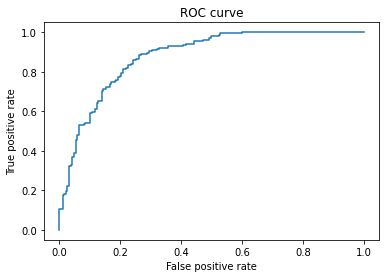

In [60]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds_siamese = roc_curve(test_y, test_preds)
auc_siamese = auc(fpr, tpr)
print('auc score : ',auc_siamese)
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_siamese))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

The roc curve was plotted and the auc score was calculated.

In [84]:
def str_sign_number(number):
  num = str(number+1)
  if len(num)==1:
    return ('0'+num)
  return num

In [86]:
counter = 0
similarity_score_txt = []
pNumber = np.unique(personNumber)
file = open('drive/YK_Challenge/similarity_score.txt','a') 
for p in test_p:
  score = str(test_preds[counter])
  score = score.replace("[", "")
  score = score.replace("]", "")
  str_score = '{},{},{},{},{}'.format(pNumber[p[:2][0]],str_sign_number(p[:2][1]),pNumber[p[2:][0]],str_sign_number(p[2:][1]),score)
  file.write(str_score)
  file.write("\n")
  print(str_score)
  counter += 1

080,01,080,02,0.8567381
080,01,020,10,0.28402448
080,02,080,03,0.9645644
080,02,064,05,-0.2562648
080,03,080,04,0.8764738
080,03,027,10,-0.43576264
080,04,080,05,0.7497641
080,04,012,12,0.44518316
080,05,080,06,0.8160845
080,05,004,08,-0.7322221
080,06,080,07,0.976609
080,06,088,07,-0.38943565
080,07,080,08,0.89650655
080,07,056,12,0.92875284
080,08,080,09,0.7981278
080,08,089,10,0.62398
080,09,080,10,0.7175832
080,09,027,09,-0.62329507
080,10,080,11,0.7987109
080,10,058,02,0.02832842
080,11,080,12,0.8623061
080,11,022,09,0.78470993
083,01,083,02,0.6534482
083,01,094,12,-0.22886217
083,02,083,03,0.6174517
083,02,004,06,0.8896157
083,03,083,04,0.43850982
083,03,021,10,0.852857
083,04,083,05,0.5408993
083,04,063,05,0.6115912
083,05,083,06,0.7458562
083,05,056,07,-0.38935864
083,06,083,07,0.49712062
083,06,084,08,0.12556934
083,07,083,08,0.47031468
083,07,096,09,0.6249844
083,08,083,09,0.25985295
083,08,042,02,-0.05767047
083,09,083,10,0.52607536
083,09,002,12,-0.3755716
083,10,083,11,0.9

Test results were written to the txt file with the person numbers, signature numbers and similarity scores.